<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to your task 1 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook.__

<b>Enter you student details below</b>

- <b>Student Name:</b> Alexander Li
- <b>Student ID:</b> 30630711  

<div class="alert alert-block alert-danger">

# Table of Contents

* [Task 1.1: Iterative weighted linear regression](#t1_1)
    
* [Task 1.2: Using non-linear features and learning rate decay for better classification](#t1_2)


<div class="alert alert-block alert-warning">

# Libraries 

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<div class="alert alert-block alert-info">


# Before you begin

Ensure that you use __numpy__ or __torch__ efficiently instead of nested for loops to perform tensor multiplications. For example, if you are doing a 4x4 tensor multiplied with a 4x4 tensor using numpy, you should use np.matmul instead of 2 for loops. We highly recommend using __numpy__ for the entire task 1, as you will resuse some of the numpy code from the labs.


# Linear and logistic regression

In this task, you will be furthering your implementations with linear and logistic regression. This builds off your previous lab and aims to explore further possibilities with these models in both numerical estimation and classification tasks.

<div class="alert alert-block alert-info">

# Task 1.1 - Iterative weighted linear regression <a class="anchor" id="t1_1"></a>

In some problems, every data point might not have the same importance. Having weights associated to samples will provide us with a principal way to model such problems. Consider a data set in which each data point $(x_i, y_i)$, $x_i \in \mathbb{R}^n$, $y_i \in \mathbb{R}$ is associated with a weighting factor $0 < \alpha_i ≤ 1$. Define the loss of a linear model with parameters $w \in \mathbb{R}^n$ as the weighted sum-of-squares error:

$$ \mathcal{L}_{\mathrm{wSE}}(\boldsymbol{w})=\frac{1}{m}\sum_{i=1}^{m}\alpha_i(w^\top x_i - y_i)^2 $$

It can be shown that the optimal weights can be obtained as: 

$$ w^* = (X^\top A X)^{-1}X^\top A Y $$

Here, $X$ is a matrix of size $m × n$ where every row is one input sample (i.e., row $i$ in $X$ is $x_i$). Similarly, $Y$ is an m dimensional vector storing $y_i$ and $A$ is a diagonal matrix of size $m × m$ with $A[i, i] = \alpha_i$.

The purpose of this task is to train an iterative linear regression model that will weight the samples as the model is being trained. You need to develop the mechanism to weigh each sample as the model is being iteratively trained. Here, the diagonal matrix $A$ is updated by using the following equation:

$$ \hat{\alpha_i} = exp(-\sigma||y_i^{noisy} - \hat{y_i}||^2) $$

,where $\sigma$ is a hyperparemeter you can tune.

## (a) Developing a generic function for (weighted) linear regression

In [58]:
# This weighted least squares function can be used for both weighted least squares 
# or a vanilla linear regression model.

# "X,Y" inputs are required by the user
# The input "A" can be defaulted to an identity matrix which would result in a vanilla linear regression model
# The output will be the least square's calculated coefficients
# It is recommended you use the least squares formula which has been derived in the lectures when calculating your linear regression coefficients

def weighted_LS(X, Y, A=np.empty(0)):
    Y = Y.reshape(-1, 1)
    m = X.shape[0] # number of inputs
    n = X.shape[1] # number of variables in one input
    w = np.random.rand(n, 1)  

    # id matrix if a not given
    if A.size == 0:
        A = np.eye(m)
    
    # xalculate optimal weight
    w = np.linalg.inv(X.T @ A @ X) @ X.T @ A @ Y

    return w

# Function to calculate the error
# We are using least squares to calculate error (i.e., MSE)
# This is basically the euclidean distance for the error measure

def error_linear_model(X, w, Y):
    m = X.shape[0] 
    Y = Y.reshape(-1, 1)
    y_pred = X @ w
    # Define MSE loss
    MSE = 1/m * np.dot((Y - y_pred).T, (Y - y_pred))

    return MSE.item() # Return MSE

## (b) Iterative weighted linear regression

Load the data: _Task1_1.npz_

In [40]:
# Data was saved in a dictionary-liked form, where the keys are ('arr_0','arr_1')
# Load the values into correct variables according to the following mapping.
# X_trn <-- X_trn
# Y_trn <-- Y_trn
# X_val <-- X_val
# Y_val <-- Y_val

data = np.load("data/Task1_1.npz")

X_trn = data["X_trn"]
Y_trn = data["Y_trn"]
X_val = data["X_val"]
Y_val = data["Y_val"]


Visualise the train and validation data. Using a scatter plot, plot train data with red dots, validation data with blue dots. Remember to put title and x, y labels, legend for your plot.

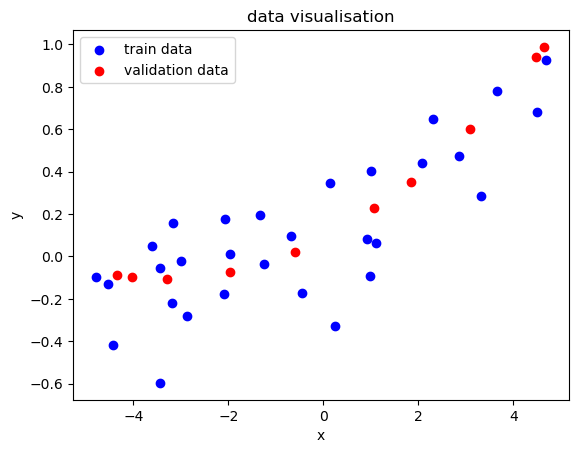

In [41]:
# Visualise the data. 

plt.figure()
plt.scatter(X_trn, Y_trn, color='b', label="train data")
plt.scatter(X_val, Y_val, color='r', label="validation data")
plt.title("data visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Since the data is non-linear, let's create non-linear features with the mapping: $ x_{aug} = [1, x, x^2, 1/x] $ for both train and validation data.

In [42]:
# Create non-linear features, do it for both train and validation data
ones_feature = np.ones((X_trn.shape[0], 1))
x_feature = X_trn.reshape(-1,1)
x2_feature = x_feature**2
one_over_x_feature = 1/x_feature
X_trn_aug = np.concatenate((ones_feature, x_feature, x2_feature, one_over_x_feature), axis=1)

ones_feature = np.ones((X_val.shape[0], 1))
x_feature = X_val.reshape(-1,1)
x2_feature = x_feature**2
one_over_x_feature = 1/x_feature
X_val_aug = np.concatenate((ones_feature, x_feature, x2_feature, one_over_x_feature), axis=1)


Implement iterative weighted linear regression. You have to tune $\sigma$ and $max\_iter$ yourself.

In [88]:
# Iteratively fit the model
sigma = 1 
max_iter = 10 # Set the max. iteration

m = X_trn_aug.shape[0] # number of inputs
n = X_trn_aug.shape[1] # number of variables in one input
w = np.random.rand(n, 1) # initialise the weight vector randomly
for num_iter in range(max_iter):
    # Fit a weighted linear regression model
    y_pred = X_trn_aug @ w
    
    # Calculate MSE of the model on validation samples
    err_val = error_linear_model(X_val_aug, w, Y_val)
    print(f"Error at iteration {num_iter}: {err_val:.4f}")
    
    # Obtain the weight of the train samples
    weights = np.exp(- sigma * (Y_trn.reshape(-1, 1) - y_pred)**2)
    A = np.diag(weights.reshape(-1))
    w = weighted_LS(X_trn_aug, Y_trn, A)

Error at iteration 0: 175.0492
Error at iteration 1: 5.1876
Error at iteration 2: 0.1245
Error at iteration 3: 0.0102
Error at iteration 4: 0.0077
Error at iteration 5: 0.0076
Error at iteration 6: 0.0076
Error at iteration 7: 0.0076
Error at iteration 8: 0.0076
Error at iteration 9: 0.0076


Now let's visualise the estimated **train data after being weighted**. Plot the original train samples in blue and the weighted samples after passing them into the model in red.

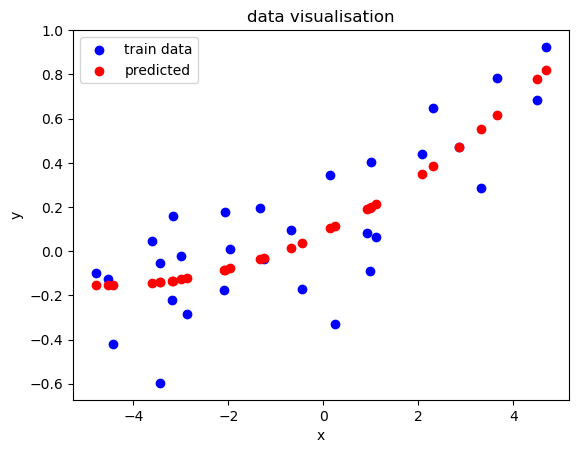

In [89]:
# Plot results.

plt.figure()
plt.scatter(X_trn, Y_trn, color='b', label="train data")
plt.scatter(X_trn, X_trn_aug @ w, color='r', label="predicted")
plt.title("data visualisation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    
# Task 1.2 - Using non-linear features and learning rate decay for better classification <a class="anchor" id="t1_2"></a>

You have been given a set of samples $x = (x_1,x_2)^\top \in \mathbb{R}^2$. In this task, you will apply the knowledge you learned from lab 2 to train a logistic model via Gradient Descent and try to improve the performance by implementing the decaying learning rate.

__Instructions:__

a. Copy any functions from Lab 2. The 3 functions you will need are: sigmoid(), predict(), compute_loss_and_grad()

b. Load and visualise data

c. Apply nonlinear transformation

d. Train the model using GD

e. Visualise the decision boundary

f. Write a decaying learning rate function

g. Train the model with decaying learning rate

## (a) Copy the required functions from lab 2 (if they were functional)

In [68]:
# Implement the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    

# Write a prediction function -> We predict the output class probability, NOT the class label (no 0,1 rounding)
def predict(X, w):

    # Input argument(s):
    # X - the input data
    # w - the weights from the trained model
    
    # Output:
    # Probability prediction of each data point (y_hat)

    # Reshape X input to have data in the columns [mxn]-->[nxm]
    X = X.T

    # Perform Matrix multiplication between the inputs and the weights
    z = w.T @ X

    # Calling Sigmoid
    y_hat = sigmoid(z)

    return y_hat.T #output y_hat as an mx1 array

def compute_loss_and_grad(X, y, y_hat):
    # Inputs:
    #    X - Set of samples (each sample is a row in X),
    #    y - Corresponding ground-truth labels
    #    y_hat - Predicted class probabilities

    # Import smallest number represented to handle log(0) edge case
    eps = 1e-12

    # Compute the mean cross-entropy loss w.r.t. the parameters w (mean as defined in lecture)
    # log(0) might throw error, so handled via small eps
    logarg1 = np.where(y_hat < eps, np.tile([eps], len(y_hat)), y_hat)
    logarg2 = np.where((1 - y_hat) < eps, np.tile([eps], len(y_hat)), 1-y_hat)
    loss = - np.mean(y*np.log(logarg1) + (1-y)*np.log(logarg2))

    # Compute the gradient vector (mean over all samples as defined in lecture)
    m = len(y)
    grad_vec = np.zeros((1,np.shape(X)[1]))
    for i in range(m):
        grad_vec += (y_hat[i] - y[i])*X[i]
    grad_vec /= m
    
    # Return loss and gradient vector
    return loss, grad_vec.transpose()

## (b) Load and visualise data

In [71]:
# Load numpy dataset from Task1_2.npz
loaded_data_task4 = np.load("data/Task1_2.npz")

# Create train and test datasets
# (X_train--> arr_0, X_test--> arr1_, Y_train_circle--> arr_2, Y_test_circle--> arr_3)
X_train = loaded_data_task4['arr_0']
X_test = loaded_data_task4['arr_1']
Y_train_circle = loaded_data_task4['arr_2']
Y_test_circle = loaded_data_task4['arr_3']

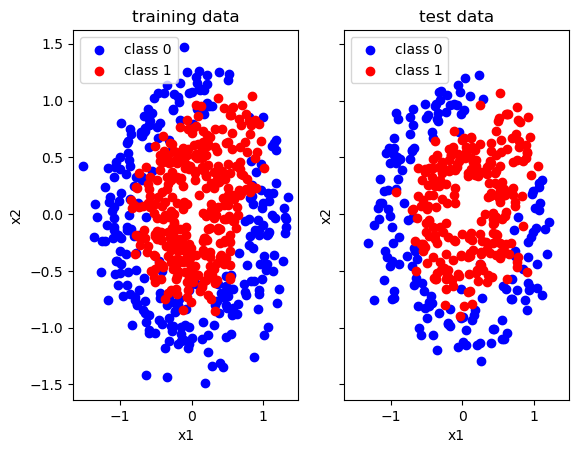

In [74]:
# Visualize non-linear features for both train and test data
# Create two plots side-by-side (Use subplots). Use scatter plots and show samples in different classes with different colours. The samples are 2-dimensional.

c0_train_ind = np.where(Y_train_circle.flatten() == 0)
c0_train = X_train[c0_train_ind]
c1_train_ind = np.where(Y_train_circle.flatten() == 1)
c1_train = X_train[c1_train_ind]

c0_test_ind = np.where(Y_test_circle.flatten() == 0)
c0_test = X_test[c0_test_ind]
c1_test_ind = np.where(Y_test_circle.flatten() == 1)
c1_test = X_test[c1_test_ind]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.scatter(c0_train[:,0], c0_train[:,1], color='b', label="class 0")
ax1.scatter(c1_train[:,0], c1_train[:,1], color='r', label="class 1")
ax2.scatter(c0_test[:,0], c0_test[:,1], color='b', label="class 0")
ax2.scatter(c1_test[:,0], c1_test[:,1], color='r', label="class 1")
ax1.title.set_text("training data")
ax2.title.set_text("test data")
ax1.legend()
ax2.legend()
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
plt.savefig("training and test data")
plt.show()


## (c) Apply nonlinear transformation

Let's map the samples with $x_{trans}=[x_1, x_2, x_1^2, x_2^2, x_1x_2, 1]$

In [75]:
# Apply nonlinear mapping
x1_feature = X_train[:,0].reshape(-1,1)
x2_feature = X_train[:,1].reshape(-1,1)
x1x2_feature = x1_feature * x2_feature
x1_feature_sq = x1_feature**2
x2_feature_sq = x2_feature**2
one_feature = np.ones((X_train.shape[0], 1))
X_trans_train = np.concatenate((x1_feature, x2_feature, x1_feature_sq, x2_feature_sq, x1x2_feature, one_feature), axis=1)

# Apply nonlinear mapping
x1_feature = X_test[:,0].reshape(-1,1)
x2_feature = X_test[:,1].reshape(-1,1)
x1x2_feature = x1_feature * x2_feature
x1_feature_sq = x1_feature**2
x2_feature_sq = x2_feature**2
one_feature = np.ones((X_test.shape[0], 1))
X_trans_test = np.concatenate((x1_feature, x2_feature, x1_feature_sq, x2_feature_sq, x1x2_feature, one_feature), axis=1)

## (d) Train the model using GD

In [77]:
# Set a random seed (Do not change!) ==============
np.random.seed(0)
# =================================================

lr=1.0 # Set the learning to be 1.0
num_epochs = 10000 # Train for 10000 epochs

loss = np.zeros(num_epochs)

m = X_trans_train.shape[0] # number of inputs
n = X_trans_train.shape[1] # number of variables in one input
theta = np.random.rand(n, 1) # Initialise theta

for ep in range(num_epochs):

    # Apply gradient descent here and record loss
    preds = predict(X_trans_train, theta)
    loss, grad_vec = compute_loss_and_grad(X_trans_train, Y_train_circle, preds)
    theta = theta - lr * grad_vec



# Evaluate the classification accuracy for training and test data

# Obtain predicted class probabilities for train and test data
y_hat_train = predict(X_trans_train, theta)
y_hat_test  = predict(X_trans_test, theta)

# Obtain actual class labels (everything >=0.5 is class1, rest class0)
c_hat_train = np.where(y_hat_train >=0.5, 1, 0)
c_hat_test = np.where(y_hat_test >= 0.5, 1, 0)

# Evaluate the classification accuracy for training and test data
acc_train = np.mean(np.where(c_hat_train == Y_train_circle, 1, 0))
acc_test = np.mean(np.where(c_hat_test == Y_test_circle, 1, 0))


print("Training accuracy: {:.3f}".format(acc_train))
print("Test accuracy: {:.3f}".format(acc_test))

Training accuracy: 0.893
Test accuracy: 0.910



## (e) Visualise the Decision Boundary

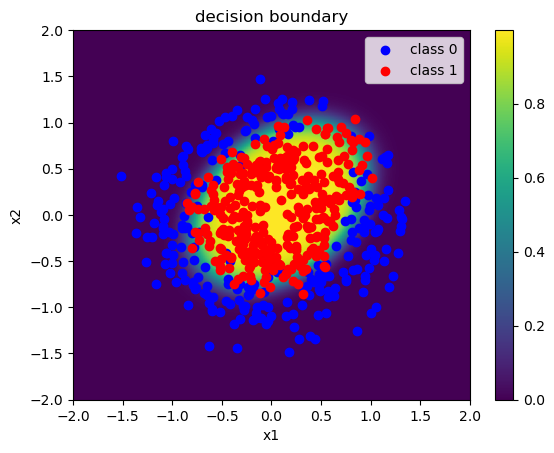

In [85]:
# You can use meshgrid and linearly spaced points to plot the decision boundary
# You may choose other ways to plot the decision boundary

xx=np.linspace(-2,2,1000)
yy=np.linspace(-2,2,1000)
[X2,Y2]=np.meshgrid(xx,yy)

f = lambda x, y, theta: sigmoid(theta[0]*x + theta[1]*y + theta[2]*x**2 + theta[3]*y**2 + theta[4]*x*y + theta[5])
Z2 = f(X2,Y2,theta)
# plot the meshgrid
plt.pcolor(X2, Y2, Z2)
plt.colorbar()
plt.scatter(c0_train[:,0], c0_train[:,1], color='b', label="class 0")
plt.scatter(c1_train[:,0], c1_train[:,1], color='r', label="class 1")
plt.title("decision boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

## (f) Write a decaying learning rate function

In [86]:
# Write a simple function to decrease current learning rate by 0.1% in each epoch
def decaying_lr(lr):
    
    
    return lr*0.999 # return the new learning rate

## (g) Train the model with decaying learning rate

In [87]:
# Set a random seed (Do not change!) ==============
np.random.seed(0)
# =================================================

lr=1.0 # Set initial learning rate to 1.0
num_epochs = 10000 # Train for 10000 epochs

loss = np.zeros(num_epochs)

m = X_trans_train.shape[0] # number of inputs
n = X_trans_train.shape[1] # number of variables in one input
theta = np.random.rand(n, 1) # Initialise theta

    
for ep in range(num_epochs):
    # Apply gradient descent here and record loss
    preds = predict(X_trans_train, theta)
    loss, grad_vec = compute_loss_and_grad(X_trans_train, Y_train_circle, preds)
    theta = theta - lr * grad_vec
    # Apply learning rate decay here
    lr = decaying_lr(lr)

    

# Evaluate the classification accuracy for training and test data

# Obtain predicted class probabilities for train and test data
y_hat_train = predict(X_trans_train, theta)
y_hat_test  = predict(X_trans_test, theta)

# Obtain actual class labels (everything >=0.5 is class1, rest class0)
c_hat_train = np.where(y_hat_train >=0.5, 1, 0)
c_hat_test = np.where(y_hat_test >= 0.5, 1, 0)

# Evaluate the classification accuracy for training and test data
acc_train = np.mean(np.where(c_hat_train == Y_train_circle, 1, 0))
acc_test = np.mean(np.where(c_hat_test == Y_test_circle, 1, 0))


print("Training accuracy: {:.3f}".format(acc_train))
print("Test accuracy: {:.3f}".format(acc_test))

Training accuracy: 0.897
Test accuracy: 0.915


<div class="alert alert-block alert-success">

## 1.3 Discussion  <a class="anchor" id="t1_3"></a>

1. What do you notice about the outliers for the implementations weighted linear regression?
    
2. In what situations, you may want to use higher dimensional features? (Answer in terms of decision boundary)

3. Why is it important to augment the bias term for this non-linear transformation? What does it actually do to the decision boundary?

4. What is the aim of applying decay in learning rate? 
    
## Answer
    
1. The outliers are further from the predicted line. 

2. When the decision boundary is highly non linear, we may want to use higher dimensional features, such that the augmented feature space becomes linearly separable again. 

3. It provides an extra degree of freedom for the data fitting function. It shifts the decision boundary off center from the origin. 

4. Applying decaying learning rate allows the model to not overstep, when near the optimum point in parameter space. Tihs allows the model to better approach the optimum point. 